In [1]:
# Imports packages

#Import linear algebra and data manipulation
import numpy as np
import pandas as pd

#Import plotting packages
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#Import machine learning
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import AllTogether as t


# Business Understanding
Based on the available data reviwed below, we ask ourself the following
questions:
1. What are the factors that could influence ratings? 
2. Would host responses and rating influence availability? 
3. Would the property neighbourhood influences availability?

# Data understanding

In [2]:
# Read the data set
df = pd.read_csv('./Airbnb listings.csv')

# Find number of listings and unique number of hosts
listings_number = df['id'].count()
hosts_number = len(df['host_id'].unique())

print("Seatle has {listings} of listings and {hosts} of hosts".format(listings=listings_number, hosts=hosts_number))


Seatle has 3818 of listings and 2751 of hosts


# Question 1: What are the factors that could influence ratings? 
To answer the first question, we need to identify a list of attributes that could influence customer ratings. 

The assumption is that property cleaning fees, the number of bathrooms, bedrooms, beds and price would impact ratings.  

We put some variables, including cleaning fees and price, into the linear regression model and the result shows moderate variablility in the dependent variables. 

We plotted the cleaning fees and review score ratings and identified that there are correlations, where low cleaning fees correspond to higher customer reviews.  

## Prepare data

In [3]:
# Selecting relevant columns to answer the questions
listings_df = df[["bathrooms", "bedrooms", "beds", "price", "cleaning_fee", "review_scores_rating"]]

# Data cleaning and prep
# Remove rows with missing values in bathrooms, bedrooms, beds columns
"""
Reason for chosen approach:  
The presence of missing values can affect the quality and integrity 
of the dataset. A significant portion of rows have missing values 
in the columns that are important for the analysis, it can introduce 
bias and affect the accuracy of predictions.
"""
remove_column = ['bathrooms','bedrooms', 'beds']
listings_df.dropna(subset=remove_column, inplace=True)

# Strip columns and change data type to float
def column_transformation(df, col_name, ch):
    """
    Perform column transformation on a DataFrame.

    This function strips specified characters from a column and changes its data type to float.

    Parameters:
    df (DataFrame): The DataFrame containing the column to be transformed.
    col_name (str): The name of the column to be transformed.
    ch (str): The characters to be removed from the column.

    Returns:
    None. The function modifies the input DataFrame in place.
    """
    df[col_name] = df[col_name].str.replace(r'[{} ,]'.format(ch), '', regex=True).astype(float)

# Strip price and cleaning_fee columns and change data type to float
column_transformation(listings_df, 'price', '$')
column_transformation(listings_df, 'cleaning_fee', '$')

# Find and fill in mean values
def filling_mean(df, column_name):
    """
    Fill missing values in a specific column of a DataFrame with the column's mean.

    This function calculates the mean of the specified column and fills any missing values
    in that column with the calculated mean.

    Parameters:
    df (pandas.DataFrame): The DataFrame containing the column to be filled.
    column_name (str): The name of the column with missing values to be filled.

    Returns:
    None: The function modifies the input DataFrame in-place by filling missing values.

    Example:
    filling_mean(my_dataframe, 'age')
    # This will fill missing values in the 'age' column of 'my_dataframe' with the mean of the column.
    """
    mean = df[column_name].mean()
    df[column_name].fillna(mean, inplace=True)

# Call the funtion to fill in the mean value
"""
Reason for chosen approach: 
When dealing with missing data, simply removing rows with missing values 
can result in a loss of valuable information. Filling in missing values 
with mean values allows me to retain more data points and maintain the 
overall integrity of the dataset.

"""
filling_mean(listings_df, "review_scores_rating")
filling_mean(listings_df, "cleaning_fee")

# Check whether there are any missing values in all columns
print(listings_df.isnull().sum())

bathrooms               0
bedrooms                0
beds                    0
price                   0
cleaning_fee            0
review_scores_rating    0
dtype: int64


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:5434: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


## Data modeling

In [4]:
# Training the model
X = listings_df[["price", "cleaning_fee"]]
y = listings_df["review_scores_rating"]

# Split data into training and test data, and fit a linear model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)
lm_model = LinearRegression(normalize=True)

# If our model works, it should just fit our model to the data. Otherwise, it will let us know.
try:
    lm_model.fit(X_train, y_train)
    y_test_preds = lm_model.predict(X_test)
    print("The r-squared score for the model using only quantitative variables was {} on {} values.".format(r2_score(y_test, y_test_preds), len(y_test)))
except:
    print("Oh no! It doesn't work!!!")


The r-squared score for the model using only quantitative variables was 0.004411376394559907 on 380 values.


## Evaluate the results

The R-squared score indicates that the linear regression model using only "price" and "cleaning_fee" as independent variables is not able to explain much of the variability in the "review_scores_rating."

This suggests that these variables alone may not be strong predictors of the review scores. It's important to note that an R-squared score close to 0 indicates that the model does not fit the data well, and additional factors may need to be considered to improve the model's predictive power.

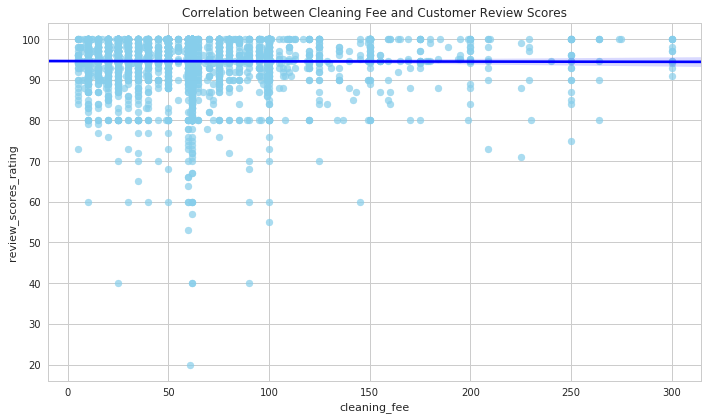

In [9]:
# Set style
sns.set(style="whitegrid")

# Create a scatter plot to visualize the correlation between cleaning fee and rating
plt.figure(figsize=(10, 6))
plt.scatter(x=listings_df["cleaning_fee"], y=listings_df["review_scores_rating"], color='skyblue', alpha=0.7)

# Set labels and title
plt.xlabel("Cleaning Fee")
plt.ylabel("Customer Review Scores")
plt.title("Correlation between Cleaning Fee and Customer Review Scores")

# Add a trendline
sns.regplot(x=listings_df["cleaning_fee"], y=listings_df["review_scores_rating"], scatter=False, color='blue')

# Show plot
plt.tight_layout()
plt.show()

### Observation

The chart illustrates the correlations between clearning fees and customer reviews. Lower clearning fees correspond to higher customer review scores. 

# Question 2: Would host responses and rating influence availability? 
To answer the second question, we need to identify a list of attributes that could influence availability.

The assumption is that host response time, host response rate , host acceptance rate, superhost and customer review scores would impact availability.

We put some variables into the linear regression model and the result shows low variablility in the dependent variables.

## Prepare data

In [15]:
# Selecting relevant columns to answer the questions
avail_factors = df[['host_response_time','host_response_rate','host_acceptance_rate', 'host_is_superhost', 'review_scores_rating', 
                    'availability_30', 'availability_60','availability_90', 'availability_365']]

# Data cleaning and prep
# Drop superhost column
"""
Reason for chosen approach:  
Machine learning algorithms, including linear regression, 
often struggle with missing values. Models might not perform well 
when trained on incomplete data, potentially leading to 
inaccurate predictions. Removing rows with missing data can help 
improve the model's performance and the quality of predictions.
"""
avail_factors.dropna(subset=['host_is_superhost'], inplace=True)

# Replace categorical values with float for model training
def categorical_replac(df, col_name, val):
    """
    Replace categorical values with numerical representation in a DataFrame column.

    This function replaces specific categorical values in a specified column with a numerical representation.
    This is useful for preparing categorical data for model training.

    Parameters:
    df (DataFrame): The DataFrame containing the column to be transformed.
    col_name (str): The name of the column where categorical values will be replaced.
    val (dict or str): A dictionary mapping categorical values to their corresponding numerical representation,
                      or a single categorical value to be replaced.

    Returns:
    None. The function modifies the input DataFrame in place.
    """
    df[col_name] = df[col_name].replace(val)
    
# Define replacement values for categorical values 
response_map = {'within a few hours': 2, 'within an hour': 1, 'within a day': 3,'a few days or more': 4}
superhost_map = {'f': 0, 't': 1}

# Call function to replace categorical value
categorical_replac(avail_factors, 'host_response_time', response_map)
categorical_replac(avail_factors, 'host_is_superhost', superhost_map)

# Calling the function to transform host_response_rate and host_acceptance_rate columns
column_transformation(avail_factors, 'host_response_rate', '%')
column_transformation(avail_factors, 'host_acceptance_rate', '%')
    
# Calling the function to fill in mean values for empty rows
"""
Reasons for the chosen approach:
When you have missing values in columns that are important for your 
analysis, like host_response_time and host_response_rate, you might 
choose to fill in these missing values with the mean to preserve 
the data points for analysis. Removing rows with missing values 
could lead to a loss of valuable information and potentially bias your 
analysis.
"""
column_names = ["host_response_time", "host_response_rate", "host_acceptance_rate", "review_scores_rating"]
[filling_mean(avail_factors, column) for column in column_names]

# Check whether the data frame has empty values
print(avail_factors.isnull().sum())

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


host_response_time      0
host_response_rate      0
host_acceptance_rate    0
host_is_superhost       0
review_scores_rating    0
availability_30         0
availability_60         0
availability_90         0
availability_365        0
dtype: int64


/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:5434: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


## Data modeling

In [16]:
## Training the model
X = avail_factors[['host_response_time','host_response_rate','host_acceptance_rate', 'host_is_superhost', 'review_scores_rating']]
y = avail_factors[['availability_30', 'availability_60']]

# Split data into training and test data, and fit a linear model
X_train, X_test, y_train, y_test = train_test_split(X, y , test_size=.10, random_state=42)
lm_model = LinearRegression(normalize=True)

# If our model works, it should just fit our model to the data. Otherwise, it will let us know.
try:
    lm_model.fit(X_train, y_train)
    y_test_preds = lm_model.predict(X_test) 
    print("The r-squared score for the model using only quantitative variables was {} on {} values.".format(r2_score(y_test, y_test_preds), len(y_test)))
    
except:
    print("Oh no! It doesn't work!!!")

The r-squared score for the model using only quantitative variables was -0.005126527088201049 on 382 values.


## Evaluate the results

A negative r-squared score of approximately -0.0051 suggests that the model does not fit the data well and the model's predictions are not capturing the patterns in the data. 

# Question 3: Would the property neighbourhood influences availability?
To answer the third question, we need to identify whether property neighbourhood would influence availability.

The assumption is that neighbourhood would impact availability.

We put some variables into the linear regression model and the result shows moderate variablility in the dependent variables

## Prepare the data

In [11]:
## Data cleaning and prep
# Selecting relevant columns to answer the questions
"""
There are no missing values in the data set.
"""
avail_factors = df[['neighbourhood_cleansed','neighbourhood_group_cleansed', 
                    'availability_30', 'availability_60','availability_90', 'availability_365']]

# Check whether the data frame has empty values
print(avail_factors.isnull().sum())

neighbourhood_cleansed          0
neighbourhood_group_cleansed    0
availability_30                 0
availability_60                 0
availability_90                 0
availability_365                0
dtype: int64


## Data modeling

In [12]:
## Training the model
X = pd.get_dummies(avail_factors[['neighbourhood_cleansed','neighbourhood_group_cleansed']])
y = avail_factors[['availability_30', 'availability_60']]

# Split data into training and test data, and fit a linear model
X_train, X_test, y_train, y_test = train_test_split(X, y , test_size=.10, random_state=42)
lm_model = LinearRegression(normalize=True)

# If our model works, it should just fit our model to the data. Otherwise, it will let us know.
try:
    lm_model.fit(X_train, y_train)
    y_test_preds = lm_model.predict(X_test) 
    print("The r-squared score for the model using only quantitative variables was {} on {} values.".format(r2_score(y_test, y_test_preds), len(y_test)))
    
except:
    print("Oh no! It doesn't work!!!")

The r-squared score for the model using only quantitative variables was -0.04826558334942599 on 382 values.


## Evaluate the results

A negative R-squared score typically indicates that the model is performing worse than a horizontal line (a line that predicts the mean of the target for all inputs), which suggests that the model doesn't fit the data well.